In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

2024-01-28 23:59:07.268321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/hugo/tensorflow-metal-test/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
#Preprocessing --- Goal to make the data compatible for CNN input
# In tensorflow, we can achieve the same using ImageGenerators

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255.)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1.0/255.)

In [3]:
#Pass the images through the generator
trainImageData = train_generator.flow_from_directory("../data/training",
                                                     batch_size=32, #how much images to give per iteration in an epoch
                                                     class_mode="binary", #Incase of multi-class classification, "categorical"
                                                     target_size=(64,64) #Ensures all images are of same size (resizing)
                                                     ) 

testImageData = train_generator.flow_from_directory("../data/testing",
                                                     batch_size=32, #how much images to give per iteration in an epoch
                                                     class_mode="binary", #Incase of multi-class classification, "categorical"
                                                     target_size=(64,64) #Ensures all images are of same size (resizing)
                                                     ) 

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


In [4]:
#Given dataset is a balanced dataset

trainImageData.class_indices

{'flip': 0, 'notflip': 1}

In [6]:
trainImageData.image_shape

(64, 64, 3)

# Learning Transferlearning with MobileNet from keras

In [7]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet, imagenet_utils
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [8]:
mobile = MobileNet()

2024-01-28 23:59:13.128878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-28 23:59:13.128930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

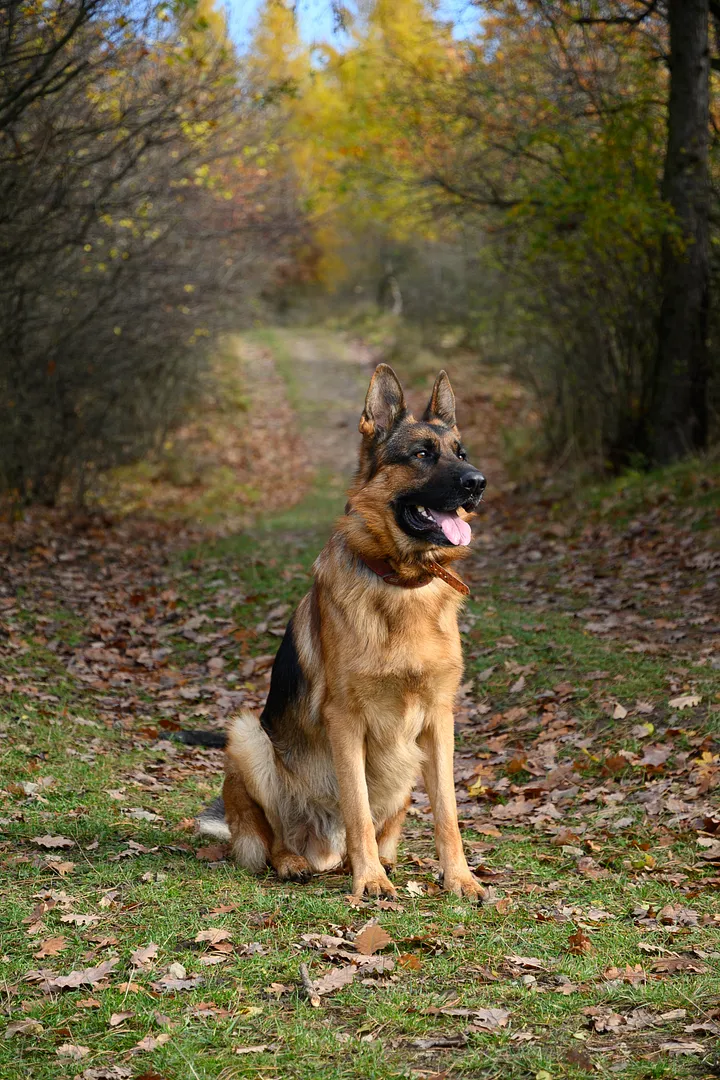

In [10]:
Image(filename='../data/German_Shepherd.jpg')

In [11]:
preprocessed_image = prepare_image('../data/German_Shepherd.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

2024-01-28 23:59:16.219353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 481ms/step


[[('n02106662', 'German_shepherd', 0.8861182),
  ('n02105162', 'malinois', 0.06191156),
  ('n02111129', 'Leonberg', 0.031066788),
  ('n02091467', 'Norwegian_elkhound', 0.00613232),
  ('n02097130', 'giant_schnauzer', 0.003302723)]]

# Retraining the final layers of MobileNet to learn and predict our images

In [12]:
# Importing the MobileNet model but discarding the last 1000 neuron layer for adjustment to our dataset
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [13]:
# Freeze the base_model
base_model.trainable = False

In [14]:
# Create the model

model = tf.keras.models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(1, activation='sigmoid')  # Single neuron for binary classification
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 2, 2, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 4,279,489
Trainable params: 1,050,625
Non-trainable params: 3,228,864
_________________________________________________________________


In [16]:
#Compile

model.compile(optimizer="adam",
              loss="binary_crossentropy", #For multi-class classification: categorical_crossentropy | sparse_categorical_crossentropy
              metrics=[tfa.metrics.F1Score(num_classes=1, threshold=0.5)])

In [17]:
len(trainImageData.filenames) // trainImageData.batch_size

74

In [18]:
# Fit the model
model.fit(trainImageData,
          validation_data=testImageData,
          epochs=10,
          steps_per_epoch = len(trainImageData.filenames) // trainImageData.batch_size,
          validation_steps= len(testImageData.filenames) // testImageData.batch_size)

Epoch 1/10


2024-01-28 23:59:29.472924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-28 23:59:30.228170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-28 23:59:30.286536: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_2.


74/74 [==============================] - ETA: 0s - loss: 0.8463 - f1_score: 0.8348

2024-01-29 00:00:00.427715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-01-29 00:00:00.581403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 39s 504ms/step - loss: 0.8463 - f1_score: 0.8348 - val_loss: 0.1724 - val_f1_score: 0.9390
Epoch 2/10
74/74 [==============================] - 37s 498ms/step - loss: 0.1317 - f1_score: 0.9533 - val_loss: 0.1363 - val_f1_score: 0.9493
Epoch 3/10
74/74 [==============================] - 37s 501ms/step - loss: 0.0894 - f1_score: 0.9706 - val_loss: 0.2024 - val_f1_score: 0.9298
Epoch 4/10
74/74 [==============================] - 37s 497ms/step - loss: 0.0748 - f1_score: 0.9750 - val_loss: 0.1082 - val_f1_score: 0.9684
Epoch 5/10
74/74 [==============================] - 37s 500ms/step - loss: 0.0589 - f1_score: 0.9799 - val_loss: 0.1278 - val_f1_score: 0.9536
Epoch 6/10
74/74 [==============================] - 37s 499ms/step - loss: 0.0626 - f1_score: 0.9748 - val_loss: 0.1093 - val_f1_score: 0.9595
Epoch 7/10
74/74 [==============================] - 37s 498ms/step - loss: 0.0316 - f1_score: 0.9881 - val_loss: 0.1068 - val_f1_score: 0.9662
Epoch 8/10

In [19]:
model.save('../models/MobileNet.keras')
#model.save('monReader.keras_tf', save_format='tf')

### Success! The MobileNet re-trained to our dataset is only 25MB, so it fits in a smartphone app! 